# Summary
In this notebook we'll look at the relations between suicide rates and other statistics about countries, such as happiness levels, economic factors, etc.. 

Rural population data: https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS?view=chart
GDP per capita PPP data: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD
GDP data: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?name_desc=false


In [1]:
CHOROPLETH_DATA_FILE = '../data/processed/choropleth_df.csv'
GDP_PER_CAPITA = '../data/raw/API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_443996/API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_443996.csv'

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [3]:
df = pd.read_csv(GDP_PER_CAPITA, skiprows=4)
df_original = pd.read_csv(CHOROPLETH_DATA_FILE)

In [4]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,35492.618487,34830.976551,36082.522486,36172.933355,35814.261438,35557.656862,35861.828118,NaN,NaN,NaN
1,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,1626.764793,1772.764974,1807.762344,1795.735834,1766.593077,1757.023490,1758.465636,1734.723214,NaN,NaN
2,Angola,AGO,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,6346.395122,6645.085625,6730.945822,6813.052106,6644.857255,6258.376628,6044.972035,5725.327238,NaN,NaN
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,10207.751719,10369.560557,10492.668465,10700.520916,10971.044395,11356.717007,11803.281802,12306.260040,NaN,NaN
4,Andorra,AND,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# remove columns we don't need, rename columns we do want
gdp = df.loc[:, ~df.columns.str.contains('^Unnamed')]
gdp = gdp.rename(columns={"Country Code": "code"}).drop(columns=["Indicator Name", "Indicator Code", "Country Name"])

# pivot
gdp = pd.melt(gdp, id_vars=['code'], var_name='year', value_name='gdp')

# only pick years we want
gdp["year"] = gdp["year"].astype(float)
gdp = gdp[(gdp["year"] < 2015) & (gdp["year"] > 1989)]

num_years = gdp["year"].nunique()
num_countries = gdp["code"].nunique()

assert len(gdp) == num_years * num_countries, "Need every unique (country, year) combination"

# get all codes which have nan values but at least two non-nan values (otherwise can't fill in others really)
null_codes = gdp[gdp["gdp"].isnull()]["code"].value_counts()
null_codes = list(null_codes[null_codes < num_years - 1].index)

# TODO: use df.interpolate() here...
# replace nans with nearest neighbours means (I checked, and this doesn't actually do anything). The nans are all
# are a block at the start or a block at the end
gdp = gdp.sort_values(by="year")
for code in null_codes:
    gdp.loc[gdp["code"] == code, "gdp"] = (gdp.loc[gdp["code"] == code,"gdp"].fillna(method='ffill') + gdp.loc[gdp["code"] == code,"gdp"].fillna(method='bfill'))/2
    
    # if just a single nan, forward fill or backward fill
    if gdp.loc[gdp["code"] == code].isnull().sum()["gdp"] < 5:
        print(code)
        gdp.loc[gdp["code"] == code,"gdp"] = gdp.loc[gdp["code"] == code,"gdp"].fillna(method='ffill')
        if gdp.loc[gdp["code"] == code].isnull().sum()["gdp"] < 5:
            gdp.loc[gdp["code"] == code,"gdp"] = gdp.loc[gdp["code"] == code,"gdp"].fillna(method='bfill')


BIH
PSE
LVA
KHM
SVK
BMU
HUN


In [6]:
gdp.head()

,code,year,gdp
7920,ABW,1990.0,37140.024657
8087,MYS,1990.0,10556.631689
8088,NAC,1990.0,36268.505731
8089,NAM,1990.0,5713.197044
8090,NCL,1990.0,NaN


In [7]:
df_original.head()

,year,sex,country,suicides_no,population,"suicides per 100,000",code
0,1979,female,Argentina,508.0,12532000.0,4.05,ARG
1,1979,female,Australia,479.0,6641600.0,7.21,AUS
2,1979,female,Barbados,0.0,119800.0,0.00,BRB
3,1979,female,Belgium,755.0,4739700.0,15.93,BEL
4,1979,female,Brazil,1074.0,51202700.0,2.10,BRA


In [8]:
# create data sets with overall suicides rates, as well as tables just for males and females.
both = df_original.groupby(['year', 'country']).agg(population = pd.NamedAgg(column="population", aggfunc=sum), 
                                                 suicides_no = pd.NamedAgg(column="suicides_no", aggfunc=sum), 
                                                 code = pd.NamedAgg(column="code", aggfunc=lambda x: x[0]),
                                                ).reset_index()
females = df_original[df_original["sex"] == "female"]
males = df_original[df_original["sex"] == "male"]
both.loc[both["population"] == 0, "population"] = np.nan
both["suicides per 100,000"] = both['suicides_no'] / both['population'] * 100000 

In [9]:
both.head()

,year,country,population,suicides_no,code,"suicides per 100,000"
0,1979,Argentina,24986000.0,1802.0,ARG,7.212039
1,1979,Australia,13279400.0,1675.0,AUS,12.613522
2,1979,Barbados,229300.0,2.0,BRB,0.872220
3,1979,Belgium,9249500.0,2114.0,BEL,22.855289
4,1979,Brazil,102206100.0,3459.0,BRA,3.384338


In [10]:
df_fused = pd.merge(both, gdp, on=["code", "year"], how="left")

In [11]:
df = df_fused[df_fused["year"] > 1989]

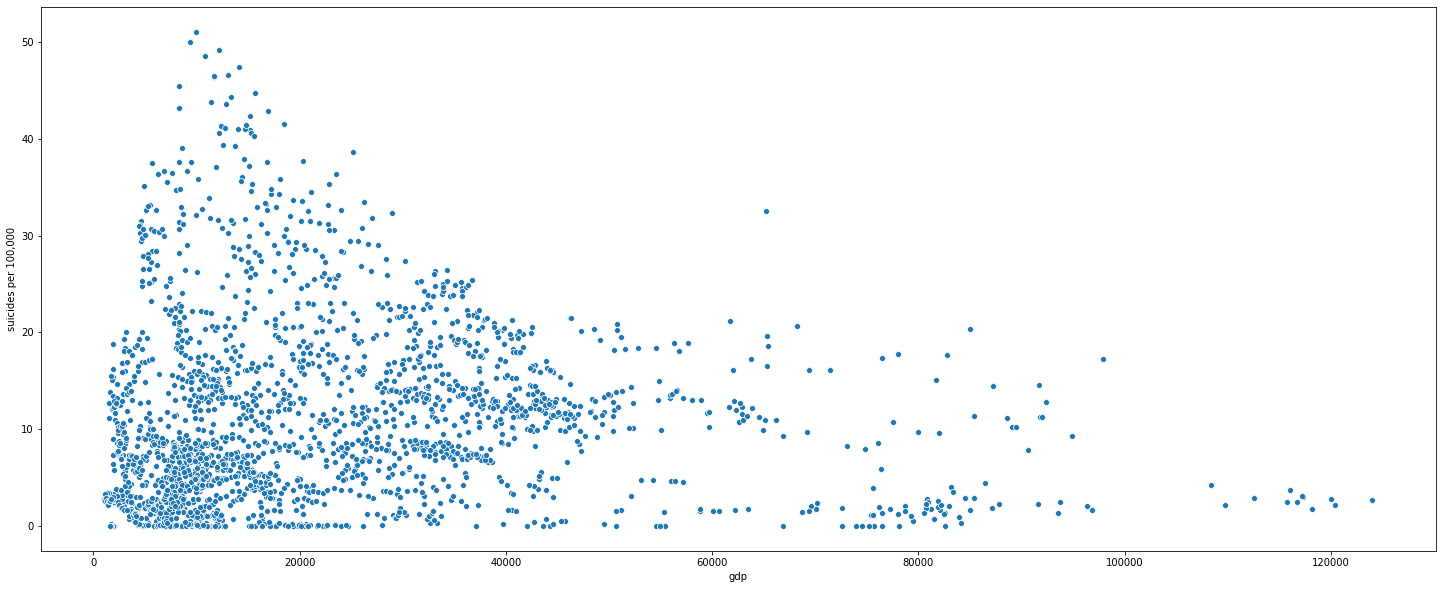

In [12]:
plt.figure(figsize=(25,10))
sns.scatterplot(x="gdp", y="suicides per 100,000", data=df)

# More features
Let's look at some other statistics on countries. Some interesting values to look at could be 
* population density (more crowded places could have higher rates because fights/riots/conflicts are more likely, and therefore people may feel worse? Or maybe in very low density places people feel more lonely?)
* hours of sunshine
* amount of rainfall
* average number of years of education in a country
* life expectancy at birth
* percentage of urban population
* etc.. etc..

## Weather features

Here I literally copy pasted hours of sunshine tables from Wikipedia, saved them in a text file, and it's surprisingly easy to get a nice datatframe. 

In [65]:
sun_asia = pd.read_csv("../data/raw/asia_sunshine.txt", sep='\t', header=0)
sun_asia.head()

,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,Ref.
0,Afghanistan,Kabul,177.2,178.6,204.5,232.5,310.3,353.4,356.8,339.7,303.9,282.6,253.2,182.4,"3,175.1",?
1,Azerbaijan,Baku,89.9,89.0,124.0,195.0,257.3,294.0,313.1,282.1,222.0,145.7,93.0,102.3,"2,207.4",?
2,Bangladesh,Dhaka,279.0,226.0,217.0,180.0,155.0,90.0,62.0,62.0,90.0,186.0,240.0,279.0,"2,066",?
3,China,Beijing,194.1,194.7,231.8,251.9,283.4,261.4,212.4,220.9,232.1,222.1,185.3,180.7,"2,670.8",?
4,China,Chongqing,20.6,29.7,64.9,93.6,109.4,97.7,158.6,167.0,106.6,50.4,35.9,20.4,954.8,?


In [66]:
sun_asia.columns

Index(['Country', 'City ', 'Jan ', 'Feb ', 'Mar ', 'Apr ', 'May ', 'Jun ',
       'Jul ', 'Aug ', 'Sep ', 'Oct ', 'Nov ', 'Dec ', 'Year ', 'Ref.'],
      dtype='object')

In [67]:
sun_asia.columns = [x.strip() for x in sun_asia.columns]

In [68]:
# # clean up a bit
sun_asia = sun_asia.drop(columns=["Ref."])
month_cols = sun_asia.columns[2:-1].values
means = sun_asia.groupby("Country").mean().reset_index()

sun_asia.head()

,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,Afghanistan,Kabul,177.2,178.6,204.5,232.5,310.3,353.4,356.8,339.7,303.9,282.6,253.2,182.4,"3,175.1"
1,Azerbaijan,Baku,89.9,89.0,124.0,195.0,257.3,294.0,313.1,282.1,222.0,145.7,93.0,102.3,"2,207.4"
2,Bangladesh,Dhaka,279.0,226.0,217.0,180.0,155.0,90.0,62.0,62.0,90.0,186.0,240.0,279.0,"2,066"
3,China,Beijing,194.1,194.7,231.8,251.9,283.4,261.4,212.4,220.9,232.1,222.1,185.3,180.7,"2,670.8"
4,China,Chongqing,20.6,29.7,64.9,93.6,109.4,97.7,158.6,167.0,106.6,50.4,35.9,20.4,954.8


In [69]:
sun_asia

,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,Afghanistan,Kabul,177.2,178.6,204.5,232.5,310.3,353.4,356.8,339.7,303.9,282.6,253.2,182.4,"3,175.1"
1,Azerbaijan,Baku,89.9,89.0,124.0,195.0,257.3,294.0,313.1,282.1,222.0,145.7,93.0,102.3,"2,207.4"
2,Bangladesh,Dhaka,279.0,226.0,217.0,180.0,155.0,90.0,62.0,62.0,90.0,186.0,240.0,279.0,"2,066"
3,China,Beijing,194.1,194.7,231.8,251.9,283.4,261.4,212.4,220.9,232.1,222.1,185.3,180.7,"2,670.8"
4,China,Chongqing,20.6,29.7,64.9,93.6,109.4,97.7,158.6,167.0,106.6,50.4,35.9,20.4,954.8
5,China,Lhasa,250.9,226.7,246.1,248.9,276.6,257.3,227.4,219.6,229.0,281.7,267.4,258.6,"2,990.2"
6,China,Shanghai,114.3,119.9,128.5,148.5,169.8,130.9,190.8,185.7,167.5,161.4,131.1,127.4,"1,775.8"
7,China,Ürümqi,101.6,128.8,180.5,248.0,283.3,282.7,298.7,301.0,262.6,224.4,127.4,84.3,"2,523.3"
8,Hong Kong,Hong Kong,143.0,94.2,90.8,101.7,140.4,146.1,212.0,188.9,172.3,193.9,180.1,172.2,"1,835.6"
9,India,Delhi,214.6,216.1,239.1,261.0,263.1,196.5,165.9,177.0,219.0,269.3,247.2,215.8,"2,684.6"


In [70]:
means.head()

,Country,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Afghanistan,177.2,178.60,204.50,232.50,310.3,353.4,356.80,339.70,303.90,282.6,253.20,182.40
1,Azerbaijan,89.9,89.00,124.00,195.00,257.3,294.0,313.10,282.10,222.00,145.7,93.00,102.30
2,Bangladesh,279.0,226.00,217.00,180.00,155.0,90.0,62.00,62.00,90.00,186.0,240.00,279.00
3,China,136.3,139.96,170.36,198.18,224.5,206.0,217.58,218.84,199.56,188.0,149.42,134.28
4,Hong Kong,143.0,94.20,90.80,101.70,140.4,146.1,212.00,188.90,172.30,193.9,180.10,172.20


## TODO:
* think of good features here, maybe the mininum hours of sunshin in a month (to get a feeling for how dark the winters are), and the mean hours of sunshine over the entire year?

## indicator data
This data was obtained from http://hdr.undp.org/en/content/human-development-index-hdi

In [19]:
data_raw = pd.read_excel("../data/raw/2018_all_indicators.xlsx")
data_raw.head()

,dimension,indicator_id,indicator_name,iso3,country_name,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,9999
0,Composite indices,146206,HDI rank,AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,168.0,NaN
1,Composite indices,146206,HDI rank,ALB,Albania,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,68.0,NaN
2,Composite indices,146206,HDI rank,DZA,Algeria,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,85.0,NaN
3,Composite indices,146206,HDI rank,AND,Andorra,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,35.0,NaN
4,Composite indices,146206,HDI rank,AGO,Angola,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,147.0,NaN


In [20]:
# We have 26 years, 1990 - 2017
data = data_raw.drop(columns=["indicator_id", "dimension", 9999, "country_name"], axis=1)
data = data.rename({"iso3": "code"}, axis=1)
data.head()

,indicator_name,code,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,HDI rank,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,168.0
1,HDI rank,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,68.0
2,HDI rank,DZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,85.0
3,HDI rank,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,35.0
4,HDI rank,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,147.0


In [22]:
# there are a lot of null values, let's see how many and let's find the features with the least null values
data["num_nulls"] = data.isnull().sum(axis=1)
list(data.sort_values(by="num_nulls")["indicator_name"].drop_duplicates(keep="first")[:40])

['Life expectancy index',
 'Mean years of schooling, male (years)',
 'Exports and imports (% of GDP)',
 'Mean years of schooling, female (years)',
 'Mean years of schooling (years)',
 'Population with at least some secondary education, male (% ages 25 and older)',
 'Population with at least some secondary education, female (% ages 25 and older)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Income index',
 'Gross national income (GNI) per capita (2011 PPP $)',
 'Expected years of schooling, male (years)',
 'Expected years of schooling, female (years)',
 'Infants lacking immunization, measles (% of one-year-olds)',
 'Infants lacking immunization, DPT (% of one-year-olds)',
 'Life expectancy at birth (years)',
 'Private capital flows (% of GDP)',
 'Remittances, inflows (% of GDP)',
 'Life expectancy at birth, male (years)',
 'Life expectancy at birth, female (years)',
 'Urban population (%)',
 'Old-age (65 and older) dependency ratio (per 100 people ages 15-64)',
 'Population 

In [24]:
# we'll use this set of features, which don't have a lot of nulls and which look like they might influence
# rates of suicide
use = ["Mean years of schooling, male (years)", "Mean years of schooling, female (years)", 
      "Population with at least some secondary education, male (% ages 25 and older)", 
      "Expected years of schooling (years)",
     "Population with at least some secondary education, female (% ages 25 and older)", 
     "Gross national income (GNI) per capita (2011 PPP $)", 
     "Infants lacking immunization, measles (% of one-year-olds)", 
     "Life expectancy at birth (years)", 
     "Urban population (%)", 
     "Education index", 
     "Human Development Index (HDI)",
     "Mortality rate, under-five (per 1,000 live births)",
      "Estimated gross national income per capita, female (2011 PPP $)", 
      "Estimated gross national income per capita, male (2011 PPP $)", 
      "Human Development Index (HDI), female", 
      "Human Development Index (HDI), male", 
      "Gender Development Index (GDI)"]

In [25]:
data2 = data[data["indicator_name"].isin(use)]
data2.columns

Index(['indicator_name',           'code',             1990,             1991,
                   1992,             1993,             1994,             1995,
                   1996,             1997,             1998,             1999,
                   2000,             2001,             2002,             2003,
                   2004,             2005,             2006,             2007,
                   2008,             2009,             2010,             2011,
                   2012,             2013,             2014,             2015,
                   2016,             2017,      'num_nulls'],
      dtype='object')

In [27]:
# all the years in our dataset
years = np.arange(1990, 2017+1)

### Fill in missing values

In [31]:
### Interpolate data. First, interpolate any missing values which are in-between nonmissing values
test = data2.copy()
test[years] = test[years].interpolate(axis=1, limit_area="inside")

# now, extrapolate data into regions with only missing values
test[years] = test[years].interpolate(axis=1, limit_direction="both", method="linear")

# check that we don't have any missing values anymore
assert test.isnull().sum().sum() == 0

test.head()

,indicator_name,code,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,num_nulls
189,Human Development Index (HDI),AFG,0.373,0.373,0.373,0.373,0.373,0.373,0.373,0.373,...,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498,12
190,Human Development Index (HDI),ALB,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785,0
191,Human Development Index (HDI),DZA,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.752,0.754,0
192,Human Development Index (HDI),AND,0.759,0.759,0.759,0.759,0.759,0.759,0.759,0.759,...,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858,10
193,Human Development Index (HDI),AGO,0.374,0.374,0.374,0.374,0.374,0.374,0.374,0.374,...,0.522,0.520,0.534,0.543,0.554,0.564,0.572,0.577,0.581,9


In [30]:
# pivot
test = pd.melt(test, id_vars=["code", "indicator_name"], var_name='year', value_name='value')
test.head()

,code,indicator_name,year,value
0,AFG,Human Development Index (HDI),1990,0.373
1,ALB,Human Development Index (HDI),1990,0.645
2,DZA,Human Development Index (HDI),1990,0.577
3,AND,Human Development Index (HDI),1990,0.759
4,AGO,Human Development Index (HDI),1990,0.374


In [32]:
test2 = test.copy()
test2 = test2.head(100)
test2.head()

,indicator_name,code,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,num_nulls
189,Human Development Index (HDI),AFG,0.373,0.373,0.373,0.373,0.373,0.373,0.373,0.373,...,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498,12
190,Human Development Index (HDI),ALB,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785,0
191,Human Development Index (HDI),DZA,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.752,0.754,0
192,Human Development Index (HDI),AND,0.759,0.759,0.759,0.759,0.759,0.759,0.759,0.759,...,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858,10
193,Human Development Index (HDI),AGO,0.374,0.374,0.374,0.374,0.374,0.374,0.374,0.374,...,0.522,0.520,0.534,0.543,0.554,0.564,0.572,0.577,0.581,9


In [34]:
# test2.pivot(index="code", values="value", columns="indicator_name").reset_index()


# # pivot
# test.pivot(columns="indicator_name", values="value")

# ## Fuse with other dataframe

# pd.merge(df, test, on=["code", "year"])

# TODO:
* clean up the feature dataframe, let the features be the columns
* try to predict suicide rates using these features